In [1]:
import cvxpy as cp
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.io
# mosek only needed if we don't use MW
#import mosek
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import cProfile
#from baselines import *
from scipy.linalg import sqrtm

from scipy.special import expit,logit 

In [2]:
#synthetic example with N datapoints, in d dimensions, with k actions, random regressors
#returns a dictionary of covariates x, labels y, regressors ell.  
def synthetic_example(N,d,k):
    #covariates
    x = np.random.normal(0,1,(N,d))
    #regressors
    ell = np.random.normal(0,1,(k,d))
    #labels
    y = np.zeros((N,k))
    for i in range(N):
        for j in range(k):
            feature = x[i,:]
            regressor = ell[j,:]
            y[i,j] = np.inner(feature,regressor) + np.random.normal(0,1)
    data = {'cov': x, 'label': y, 'reg': ell}
    return data

from scipy.special import logit, expit

def logistic_synthetic_example(N,d,k,eta,corrupt=False):
    #covariates, scaling the covariates to be of large norm amplifies the effect of corruptions
    #good parameters: scale x by 100, d = 100, N = 1000
    x = np.random.normal(0,1,(N,d))*100
    #regressors
    ell = np.random.normal(0,1,(k,d))
    ell = ell/np.linalg.norm(ell)
    #labels
    y = np.zeros((N,k))
    prob_list = np.zeros((N,k))
    for i in range(N):
        for j in range(k):
            feature = x[i,:]
            regressor = ell[j,:]
            prob = expit(np.inner(feature,regressor))
            prob_list[i,j] = prob
            y[i,j] = np.random.binomial(1,prob)
            #deterministic labels
            #if prob > 0.5:
            #    y[i,j] = 1
            #else:
            #    y[i,j] = 0
    if corrupt:
        corr = int(eta*N)
        print('number of corruptions')
        print(corr)
        poison = False
        if poison:
            print('TODO: poisoning')
        else: 
            select = np.zeros((corr,k))
            for j in range(k):
                order = np.argsort(prob_list[:,j])
                select[:,j] = order[:corr]
            for i in range(corr):
                for j in range(k):
                    index = int(select[i,j])
                    y[index,j] = 1 - y[index,j]
    data = {'cov': x, 'label': y, 'reg': ell}
    return data

#data = synthetic_example(1000,100,10)    
#print(data)

import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels


data_mode = 'logistic_synth'
#data_mode = 'synthetic'
#data_mode = 'real'
N = 1000
d = 2
k = 1
eta = 0.1

if data_mode == 'logistic_synth':
    data = logistic_synthetic_example(N,d,k,eta,corrupt=True)
    #data = logistic_synthetic_example(N,d,k,eta,corrupt=False)
if data_mode == 'synthetic':
    data = synthetic_example(1000,10,10)    
elif data_mode == 'real': 
    x, y = parse_data("Bibtex_data.txt")
    print(x.shape)
    print(y.shape)
    data = {'cov': x, 'label': y}

x = data['cov']
y = data['label']

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=0, fit_intercept ='False')
#a = np.zeros((2,3)).reshape(-1,1)
#b = np.ones(2)

#a = np.zeros(10,2).reshape(-1, 1)
#b = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
lab = y[:,0]
model.fit(x, lab)
print(model.coef_)
print(data['reg'])
print('score')
print(model.score(x,lab))

vanilla = model.coef_

number of corruptions
100
[[-0.0006328  -0.01129966]]
[[-0.0867324  -0.99623165]]
score
0.707


In [3]:
#logistic regression version of scram
from scipy.linalg import eigh

def logistic_reg_oracle(x,y,mode='robust-logistic'):
    if mode == 'robust-logistic':
        lr = 0.1
        #lam = 0.2
        #BUG FIX for lam > 0
        lam = 0.0
        MW_steps = 30
        #eta = 0.1
        AM_steps = 30
        params = (AM_steps,lr,lam,MW_steps,eta)
        regressor = logistic_scram(x,y,params)
    return regressor

def logistic_scram(x,y,params):
    AM_steps = params[0]
    altmin_params = params[1:]
    N,d = x.shape
    w = [0.]*d
    a = [1.]*N
    #TODO: fix isotropic step, for now identity covariance
    #iso_x, Sig_sqrt = isotropic(x)
    iso_x = x
    Sig_sqrt = np.eye(d)
    for i in range(AM_steps):
        w,a = logistic_altmin_step(iso_x,y,a,altmin_params)
    final_w = np.matmul(Sig_sqrt,w)    
    return final_w

def logistic_altmin_step(Xs,Ys,a,params):
    N,d = Xs.shape
    w = weighted_logistic_reg(Xs,Ys,a)
    a = logistic_get_weights(Xs,Ys,w,params)
    return w, a

def weighted_logistic_reg(x,y,a):
    n,d = x.shape
    hard_weights = np.zeros(n)
    m = min(int(n*(1 - eta))+1,n) 
    prob = a*m
    for i in range(len(a)):
        ind = np.random.binomial(1,prob[i])
        hard_weights[i] = ind
    
    N_train = int(np.sum(hard_weights))
    #print('N_train: ',N_train)
    x_train = np.zeros((N_train,d)) 
    y_train = np.zeros(N_train)
    
    hold = 0
    for i in range(len(a)):
        if hard_weights[i] == 1:
            x_train[hold,:] = x[i,:]
            y_train[hold] = y[i]
            hold = hold + 1
    model = LogisticRegression(solver='liblinear', random_state=0, fit_intercept ='False')
    model.fit(x_train, y_train)
    regressor = model.coef_[0,:]
    return regressor

def logistic_get_weights(X,y,w,params):
    n,d = X.shape
    lr,lam,steps,eta = params
    a = np.ones(n)/float(n)
    #Sig = np.cov(X.T)
    Sig = np.matmul(X.T,X)
    Xw = np.matmul(X,w)
    pred = expit(Xw)
    resids = np.absolute(y - pred)

    for j in range(steps):
        if lam > 0:
            v = v_step(a,X,Sig,eta)
        else:
            v = np.zeros(d)
        a = a_step(a,X,resids,v,lr=lr,lam=lam,eta=eta,n=n)
    return a

def outerprod(a,X):
    """ Compute X^T diag(a) X """
    left = np.multiply(X.T,a)
    return np.dot(left,X)

def cap(a,m):
    if np.max(a) <= 1./m:
        return a
    #sorted_a = np.sort(a)
    ## BUG FIX: use -a to get descending order
    sort_ids = np.argsort(-a)
    # Faster code
    Z = np.sum(a)
    for i in range(1,m + 1):
        Z -= a[sort_ids[i - 1]]
        aprime_next = (m - i) * a[sort_ids[i]]/float(m * Z)
        if aprime_next <= 1.0/m:
            aprime = np.copy(a)
            aprime[sort_ids[:i]] = 1./m
            aprime[sort_ids[i:]] *= (m - i)/float(m * Z)
            return aprime

def v_step(a,X,Sig,eta,tol=0):
    """ Compute top eigenvector of X^T diag(1/n-a) X"""
    # Bug fix: this was formerly 1 and not 1/n
    n = a.shape[0]
    M = outerprod(1./n-a,X)

    # this method is slower sometimes and faster sometimes vs other one, depending on d?
    d = M.shape[0]

    # Want top eigenvalue algebraically
    eigenvalue, v = eigh(M, eigvals=(d-1,d-1)) 
    #eigenvalue, v = largest_eigsh(M, 1, which='LA',tol=tol)
    
    ## Don't regularize if constraint is satisfied
    if eigenvalue > 0:
        return v[:,0]
    else:
        return np.zeros(shape=v[:,0].shape)
    
# @jit(nopython=True)
def a_step(a,X,resids_sq,v,lr,lam,eta,n):
    """ Step to minimize \sum_i a_i resids_sq[i]^2 + \lambda sigma_{max}(X^T diag(1/n - a) X)"""
    m = min(int(n*(1 - eta))+1,n) 
    
    Xv_squared = np.dot(X,v)**2
    penalties = resids_sq - lam * Xv_squared

    a *= np.exp(-lr * penalties)
    a /= np.sum(a)
    a = cap(a,m)
    return a

def logistic_eval(x,y,reg):
    n,d = x.shape
    error = 0
    for i in range(n):
        error = error + np.absolute(y[i] - expit(np.inner(reg,x[i,:])))
        
    error = error/n
    return error 
    
reg = logistic_reg_oracle(x,y[:,0])
print('non robust performance: ', logistic_eval(x,y,vanilla))
print('robust performance: ',logistic_eval(x,y,reg))
print('vanilla: ', vanilla)
print('reg: ', reg)

first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
non robust performance:  [0.38377222]
robust performance:  [0.19446745]
vanilla:  [[-0.0006328  -0.01129966]]
reg:  [-0.00458431 -0.05588499]


In [4]:
#plot experiments for logistic regression
d_list = [50,100,150,200,250]
eta_list = [0.05,0.1,0.15,0.2,0.25]

def run_experiment():
    N = 1000
    k = 1
    dv_out = np.zeros((len(d_list),len(eta_list)))
    dr_out = np.zeros((len(d_list),len(eta_list)))
    print("init dv_out: ", dv_out.shape)
    print('init dr_out: ', dr_out.shape)
    index = 0
    for d in d_list: 
        results_robust = []
        results_vanilla = []
        for eta in eta_list: 
            data = logistic_synthetic_example(N,d,k,eta,corrupt=True)
            #data = logistic_synthetic_example(N,d,k,eta,corrupt=False)
            x = data['cov']
            y = data['label']
            #run vanilla logistic regression
            from sklearn.linear_model import LogisticRegression
            model = LogisticRegression(solver='liblinear', random_state=0, fit_intercept ='False')
            lab = y[:,0]
            model.fit(x, lab)
            vanilla = model.coef_
            #run robust logistic regression
            import time
            start = time.process_time()
            reg = logistic_reg_oracle(x,lab)
            print('TIME: ',time.process_time() - start)
            v_out = logistic_eval(x,y,vanilla)
            r_out = logistic_eval(x,y,reg)
            results_robust.append(r_out)
            results_vanilla.append(v_out)
            print('corruption level: ',eta)
            print('non robust performance: ', v_out)
            print('robust performance: ', r_out)
        print("dv_out: ", dv_out.shape)
        print('dr_out: ', dr_out.shape)
        dv_out[index,:] = results_vanilla
        dr_out[index,:] = results_robust
        index = index + 1
    return (dr_out,dv_out)  

(rob,nrob) = run_experiment()
print('robust: ', rob)
print('non robust: ', nrob)

init dv_out:  (5, 5)
init dr_out:  (5, 5)
number of corruptions
50
first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
TIME:  3.4377340000000007
corruption level:  0.05
non robust performance:  [0.25815145]
robust performance:  [0.10620308]
number of corruptions
100
first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
TIME:  8.913887000000003
corruption level:  0.05
non robust performance:  [0.24820758]
robust performance:  [0.08541078]
number of corruptions
100
first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
TIME:  14.971988999999994
corruption level:  0.05
non robust performance:  [0.22585695]
robust performance:  [0.11217551]
number of corruptions
100
first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
TIME:  18.812216000000006
corruption level:  0.05
non robust performance:  [0.19896414]
robust performance:  [0.07228565]
number of corruptions
100
first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
TIME:  18.233540000000005
corruption level:  0.05
non robust performance:  [0.19805063]
robust performance:  [0.06669183]
number of corruptions
100
first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
TIME:  36.858442
corruption level:  0.1
non robust performance:  [0.27374196]
robust performance:  [0.09994039]
number of corruptions
150
first length of a: 1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
length of a:  1000
le

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2,2)
 
# Accessing each axes object to plot the data through returned array
for i in range(2):
    for j in range(2): 
        ax[i,j].plot(eta_list,rob[i,:],label='robust')
        ax[i,j].plot(eta_list,nrob[i,:],label='logistic')
        ax[i,j].set(xlabel = 'fraction corrupted', ylabel='fraction misclassified')
        ax[i,j].legend(loc='lower right', shadow=True)
        ax[i,j].set_title('Logistic Regression vs. Logistic SCRAM dim=' + str(d_list[i]))

fig.tight_layout()
plt.show()

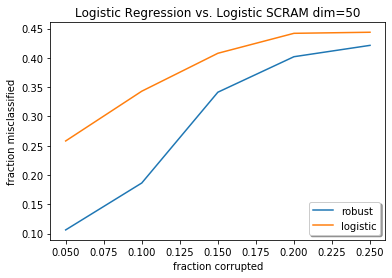

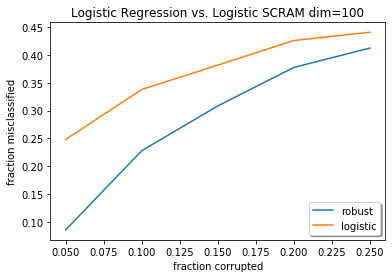

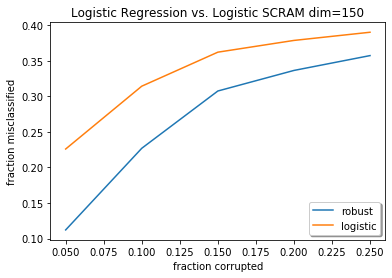

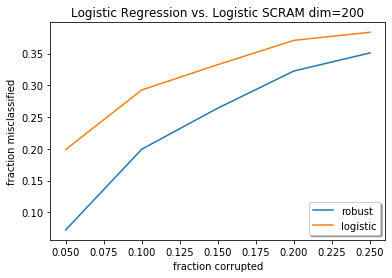

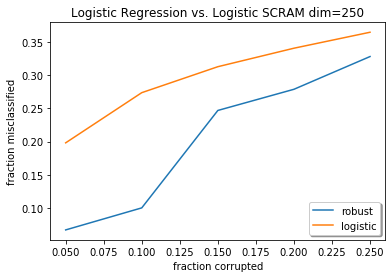

In [5]:
for i in range(len(d_list)):
    plt.plot(eta_list,rob[i,:],label='robust')
    plt.plot(eta_list,nrob[i,:],label='logistic')
    plt.xlabel('fraction corrupted')
    plt.ylabel('fraction misclassified')
    plt.legend(loc='lower right', shadow=True)
    plt.title('Logistic Regression vs. Logistic SCRAM dim=' + str(d_list[i]))
    plt.savefig('sample' + str(i) + '.png')
    plt.show()

In [ ]:
from mw2 import MW_no_alt_min, get_weights, altmin_step

def isotropic(Xs,fake=False):
    if fake:
        return Xs, np.eye(Xs.shape[1])
    Sig = np.matmul(Xs.T,Xs)
    Sig_sqrt = np.linalg.inv(sqrtm(Sig))
    new_Xs = np.matmul(Xs,Sig_sqrt)
    return new_Xs, Sig_sqrt

def scram(x,y,params):
    AM_steps = params[0]
    altmin_params = params[1:]
    N,d = x.shape
    w = [0.]*d
    a = [1.]*N
    #iso_x, Sig_sqrt = isotropic(x)
    iso_x = x
    Sig_sqrt = np.eye(d)
    AM_steps = 1
    for i in range(AM_steps):
        #print('AM step: ',i)
        w,a = altmin_step(iso_x,y,a,altmin_params,init=False)
    final_w = np.matmul(Sig_sqrt,w)    
    return final_w

#regression oracle 
def regression_oracle(x,y,mode='ols'):
    if mode == 'ols':
        model = LinearRegression()
        model.fit(x,y)
        regressor = model.coef_
    if mode == 'scram':
        lr = 0.5
        lam = 0.2
        MW_steps = 10
        eta = 0.1
        AM_steps = 10
        params = (AM_steps,lr,lam,MW_steps,eta)
        regressor = scram(x,y,params)
    return regressor


reg = regression_oracle(x,y[:,0])

def optimal_reward(y):
    a,b = y.shape
    cumsum = 0
    for i in range(a):
        cumsum = cumsum + np.amax(y[i,:])
    return cumsum/a

max_reward = optimal_reward(y)
print('Optimal Reward')
print(max_reward)

In [ ]:
#contextual bandits takes covariates and labels
def contextual_bandit(cov_label):
    cov = cov_label['cov']
    labels = cov_label['label']
    (N,d) = cov.shape
    (N,k) = labels.shape
    estimators = np.zeros((k,d))
    action_list = []
    mu = k
    delta = 0.1
    gamma = np.sqrt(k*N/(d*np.log(N/d) + 1./(2*delta)))
    params = (mu,gamma)
    rewards = []
    mean_reward = []
    for i in range(N):
        print('iteration: ',i)
        covariate = cov[i,:]
        values = np.zeros(k)
        for j in range(k):
            est = estimators[j,:]
            values[j] = np.inner(est,covariate)
        action = select_action(values,params)
        action_list.append(action)
        bandit_feedback = labels[i,action]
        rewards.append(bandit_feedback)
        (data_x,data_y) = get_data(cov_label,action_list,action) 
        
        #bug, ols can run on one datapoint but scram can't
        estimators[action,:] = logistic_reg_oracle(data_x,data_y)
        #estimators[action,:] = regression_oracle(data_x,data_y,mode='ols')
        #estimators[action,:] = regression_oracle(data_x,data_y,mode='scram')
        print('action')
        print(action)
        print('average reward')
        #print(rewards)
        avg_reward = sum(rewards)/len(rewards)
        mean_reward.append(avg_reward)
        print(avg_reward)
    return mean_reward

def get_data(cov_label,action_list,action):
    cov = cov_label['cov']
    labels = cov_label['label']
    (N,d) = cov.shape
    (N,k) = labels.shape
    length = len(action_list)
    count = 0
    for i in range(length):
        if action_list[i] == action:
            count = count + 1
    
    data_x = np.zeros((count,d))
    data_y = np.zeros(count)
    counter = 0
    for i in range(len(action_list)):
        if action_list[i] == action:
            data_x[counter] = cov[i,:]
            data_y[counter] = labels[i,action]
            counter = counter + 1
    return (data_x,data_y) 


def select_action(values,params):
    (mu,gamma) = params
    k = mu
    max_value = np.amax(values)
    max_index = np.where(values == max_value)[0][0]
    prob = np.zeros(len(values))
    for i in range(k): 
        if i == max_index:
            next
        else: 
            prob[i] = 1./(mu + gamma*(max_value - values[i]))
    prob[max_index] = 1 - np.sum(prob)
    prob = prob/np.sum(prob)
    #print('probability')
    #print(prob)
    #TODO roulette wheel
    draw = np.random.rand()
    sums = 0
    action = 0
    for i in range(k):
        sums = sums + prob[i]
        if sums >= draw:
            action = i
            break
    return action

mean_reward = contextual_bandit(data)